In [34]:
import json
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm 
import torch
from torch_geometric.data import Data
import torch.nn as nn
from torch_geometric.nn import GCNConv
import torch.nn.functional as F
from torch_geometric.loader import DataLoader
import pandas as pd
from sklearn.preprocessing import StandardScaler
import difflib

import sys
sys.path.append('../AJA')
import AJA as aja

In [42]:
from sklearn.preprocessing import StandardScaler

def compter_mots(phrase):
    mots = phrase.split()  # Divisez la phrase en mots en utilisant les espaces comme délimiteurs
    return len(mots)

def calculate_similarity(text, neighbors, df):
    max_similarity = 0.0
    if isinstance(neighbors, list):
        for neighbor in neighbors:
            if neighbor != []:
                if isinstance(neighbor, int):
                    neighbor_index = neighbor
                else:
                    neighbor_index = neighbor[0]
                neighbor_text = df.iloc[neighbor_index]['text']
                matcher = difflib.SequenceMatcher(None, text.split(), neighbor_text.split())
                similarity = matcher.ratio()
                max_similarity = max(max_similarity, similarity)
    elif isinstance(neighbors, int):
        # Handle the case where 'neighbors' is an integer directly
        neighbor_index = neighbors
        neighbor_text = df.iloc[neighbor_index]['text']
        matcher = difflib.SequenceMatcher(None, text.split(), neighbor_text.split())
        max_similarity = matcher.ratio()
    return max_similarity



def f(df_nodes, df_edges):

    df = df_nodes.copy()
    """
    # sentence length normalized
    df['sentence_length'] = df['text'].apply(lambda s: len(s.split()))
    scaler = StandardScaler()
    df['sentence_length'] = scaler.fit_transform(df['sentence_length'].values.reshape(-1, 1))

    # speaker hot-one encoding
    one_hot_encoded = pd.get_dummies(df['speaker_int'], prefix='speaker', dtype='int')
    df = pd.concat([df, one_hot_encoded], axis=1)

    df['nb_mots'] = df['text'].apply(compter_mots)
    df['nb_interrogations'] = df['text'].apply(lambda x: x.count('?'))
    df['nb_occurences'] = df['text'].apply(lambda x: sum(x.split().count(mot) for mot in ['uh', 'um', 'okay', '<', 'ah', 'oh']))
    df['nb_words_more_5'] = df['text'].apply(lambda x: sum(len(mot) > 5 and mot.lower() != '<vocalsound>' for mot in x.split()))

    # Calcul de la colonne 'neighb'
    df_edges_grouped = df_edges.groupby(['transcription', 'start'])['end'].apply(list).reset_index()
    df = pd.merge(df, df_edges_grouped, how='left', left_on=['transcription', 'line'], right_on=['transcription', 'start'])
    df = df.rename(columns={'end': 'neighb'})

    # Calcul de la colonne 'similarities'
    df['similarities'] = df.apply(lambda row: calculate_similarity(row['text'], row['neighb'],df), axis=1)
"""
    df = df.drop(['text', 'speaker_int', 'speaker_text'], axis=1)

    #df = df.drop(['text', 'speaker_int', 'speaker_text', 'start', 'neighb'], axis=1)
    print(df)
    return df

def g(df):
    new_df = pd.DataFrame({
        'transcription': df['transcription'],
        'start': df['end'],
        'end': df['start'],
        'type_int': 16 + df['type_int'],
        'type_text': df['type_text'] + "_reverse"
    })
    result_df = pd.concat([df, new_df], ignore_index=True)
    return result_df


In [43]:
train_graphs, validation_graphs, test_graphs = aja.get_graphs(f, g, 0.3)

      transcription  line  label    bert_0    bert_1    bert_2    bert_3  \
0           ES2002a     0      0 -0.057809 -0.085828 -0.035720 -0.011185   
1           ES2002a     1      0 -0.054862  0.047607 -0.032626 -0.010949   
2           ES2002a     2      1 -0.054665 -0.073837 -0.017161 -0.064276   
3           ES2002a     3      0 -0.010416 -0.072719 -0.017206 -0.088992   
4           ES2002a     4      0 -0.028654 -0.015151  0.095910 -0.059113   
...             ...   ...    ...       ...       ...       ...       ...   
72618       TS3012d  1278      0 -0.053178 -0.023260  0.015400  0.038154   
72619       TS3012d  1279      0  0.003147  0.003671 -0.018923  0.019250   
72620       TS3012d  1280      0 -0.129198  0.035191  0.014236  0.033648   
72621       TS3012d  1281      0 -0.108031 -0.013967 -0.014813  0.032640   
72622       TS3012d  1282      0 -0.146411  0.005653 -0.009107 -0.006575   

         bert_4    bert_5    bert_6  ...  bert_374  bert_375  bert_376  \
0      0.0623

In [44]:
# on check la forme des input
shape_df = train_graphs['ES2002a'].x.shape[1]

In [45]:
class MultiChannelsGCN(torch.nn.Module):
    
    def __init__(self, channels, input_dim, post_conv_dim, output_dim, identity=False):
        super(MultiChannelsGCN, self).__init__()
        self.identity = identity
        self.channels = channels
        self.input_dim = input_dim
        self.post_conv_dim = post_conv_dim
        self.output_dim = output_dim
        self.GCN = nn.ModuleList([GCNConv(input_dim, post_conv_dim) for _ in range(channels)])
        if identity:
            self.dense = nn.Linear(post_conv_dim * (channels + 1), output_dim)
            self.denseID = nn.Linear(input_dim, post_conv_dim)
        else:
            self.dense = nn.Linear(post_conv_dim * channels, output_dim)

    def forward(self, nodes, edges):
        X = []
        for k in range(self.channels):
            if len(edges[k]) == 0:
                x = torch.zeros(nodes.shape[0], self.post_conv_dim)
            else:
                x = F.relu(self.GCN[k](nodes, edges[k]))
            X.append(x)
        if self.identity:
            X.append(F.relu(self.denseID(nodes)))
        concat = torch.cat(X, dim=1)
        return F.relu(self.dense(concat))

In [50]:
# on définie son plus beau modèle

class NodeClassifier(torch.nn.Module):
    def __init__(self, channels, input_dim):
        super(NodeClassifier, self).__init__()
        self.threshold = 0.5
        self.GCN1 = MultiChannelsGCN(channels, input_dim, 50, 20, identity=True)
        self.dropout = nn.Dropout(0.3)  # Couche de dropout
        self.dense1 = nn.Linear(20, 1)

    def forward(self, data):
        nodes, edges = data.x, data.edge_index
        
        x = self.GCN1(nodes, edges)
        x = self.dense1(x)
        return x

    def set_threshold(self, t):
        self.threshold = t

    def predict(self, graph):
        self.eval()
        with torch.no_grad():
            logits = self.forward(graph)
            predictions = torch.sigmoid(logits)
        return np.array((predictions > self.threshold).int()).flatten()

In [51]:
# Charger l'extension autoreload
%load_ext autoreload

# Configurer autoreload pour recharger tous les modules avant l'exécution de chaque cellule
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [52]:
# on instancie le modèle
model = NodeClassifier(32,shape_df)

# on définie la fonction de perte et l'optimiseur
#criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

alpha = 0.2  # Paramètre de pondération (ajustez selon votre cas)
gamma = 5  # Paramètre de focalité (ajustez selon votre cas)
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor((1 - alpha) / alpha), reduction='mean')


model.set_threshold(0.59)

# on entraine !

for epoch in range(15):
    loss = aja.train(model, train_graphs, optimizer, criterion)
    print('- Epoch', f'{epoch:03d}', '-')
    print('Loss:',  f'{loss:.4f}')
    f1_train = aja.f1_score_moyen(model, train_graphs)
    f1_valid = aja.f1_score_moyen(model, validation_graphs)
    print('F1 train:', f1_train)
    print('F1 valid:', f1_valid)
    torch.save(model.state_dict(), "training_states/"+str(epoch) + ".pth")
    print('')

- Epoch 000 -
Loss: 60.1241
F1 train: 0.5603026708165343
F1 valid: 0.5000523932199094

- Epoch 001 -
Loss: 48.8974
F1 train: 0.5795191708416578
F1 valid: 0.5156167369782338

- Epoch 002 -
Loss: 47.1602
F1 train: 0.5850798356086938
F1 valid: 0.5149066693043765

- Epoch 003 -
Loss: 45.7995
F1 train: 0.5970329730734732
F1 valid: 0.5228578908770934

- Epoch 004 -
Loss: 44.7108
F1 train: 0.6080100632598587
F1 valid: 0.5274463134194332

- Epoch 005 -
Loss: 43.6501
F1 train: 0.6197894506119798
F1 valid: 0.5311831934138778

- Epoch 006 -
Loss: 42.5376
F1 train: 0.6308002108420916
F1 valid: 0.534330219112459

- Epoch 007 -
Loss: 41.2910
F1 train: 0.6428286695212279
F1 valid: 0.5377168129435406

- Epoch 008 -
Loss: 39.9017
F1 train: 0.6538393937952888
F1 valid: 0.5376058425236403

- Epoch 009 -
Loss: 38.3689
F1 train: 0.6682248880305891
F1 valid: 0.5375822682652803

- Epoch 010 -
Loss: 36.7669
F1 train: 0.6811490080479483
F1 valid: 0.5348535666203676

- Epoch 011 -
Loss: 35.1129
F1 train: 0.6957

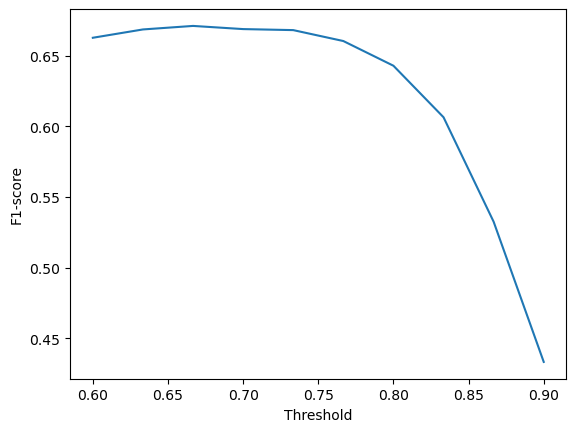

In [ ]:
# on peut revenir à un modèle intermédiaire pour éviter l'overfitting
epoch_opt = 21
model.load_state_dict(torch.load("training_states/"+str(epoch_opt)+".pth"))

T = np.linspace(0.6,0.9,10)
f1s = []
for t in T:
    model.set_threshold(t)
    f1_valid = aja.f1_score_moyen(model, validation_graphs)
    f1s.append(f1_valid)

plt.plot(T, f1s)
plt.xlabel('Threshold')
plt.ylabel('F1-score')
plt.show()

In [ ]:
# quand on est content on fait une submission !
model.set_threshold(0.73)
aja.make_test_csv_submission(model, test_graphs, 'alice-features')